## Code for: `DL1.ipynb`

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# NAND gate dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # Inputs
Y = np.array([[1], [1], [1], [0]])  # Outputs


In [3]:
# Create a neural network model
model = Sequential([
    Dense(4, input_dim=2, activation='relu'),  # Hidden layer with 4 neurons
    Dense(1, activation='sigmoid')  # Output layer
])

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
# Train the model
model.fit(X, Y, epochs=1000, verbose=0)

In [6]:
# Test the model
predictions = model.predict(X)
binary_predictions = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [7]:
# Display results
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted Output: {binary_predictions[i][0]}")

Input: [0 0], Predicted Output: 1
Input: [0 1], Predicted Output: 1
Input: [1 0], Predicted Output: 1
Input: [1 1], Predicted Output: 0


## Code for: `DL2.ipynb`

In [1]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Generate synthetic binary classification data
def generate_data(n_samples=1000):
    np.random.seed(1)
    X = np.random.randn(n_samples, 2)
    y = (X[:, 0] * X[:, 1] > 0).astype(int)  # non-linear boundary
    return X, y.reshape(-1, 1)

In [4]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
# Loss with L2 regularization
def compute_loss(y, y_hat, weights, l2_lambda):
    m = y.shape[0]
    cross_entropy = -np.mean(y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8))
    l2_penalty = (l2_lambda / (2 * m)) * np.sum(weights**2)
    return cross_entropy + l2_penalty

In [6]:
# Gradient of loss
def compute_gradients(X, y, y_hat, weights, l2_lambda):
    m = y.shape[0]
    dw = (1/m) * (X.T @ (y_hat - y)) + (l2_lambda / m) * weights
    db = (1/m) * np.sum(y_hat - y)
    return dw, db

In [7]:
# Optimizer implementations
class Optimizer:
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, w, dw, b, db):
        raise NotImplementedError

In [8]:
class SGD(Optimizer):
    def step(self, w, dw, b, db):
        return w - self.lr * dw, b - self.lr * db

In [9]:
class Momentum(Optimizer):
    def __init__(self, lr=0.01, beta=0.9):
        super().__init__(lr)
        self.vw = 0
        self.vb = 0
        self.beta = beta

    def step(self, w, dw, b, db):
        self.vw = self.beta * self.vw + (1 - self.beta) * dw
        self.vb = self.beta * self.vb + (1 - self.beta) * db
        return w - self.lr * self.vw, b - self.lr * self.vb

In [10]:
class RMSProp(Optimizer):
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        super().__init__(lr)
        self.sw = 0
        self.sb = 0
        self.beta = beta
        self.epsilon = epsilon

    def step(self, w, dw, b, db):
        self.sw = self.beta * self.sw + (1 - self.beta) * (dw**2)
        self.sb = self.beta * self.sb + (1 - self.beta) * (db**2)
        w_update = self.lr * dw / (np.sqrt(self.sw) + self.epsilon)
        b_update = self.lr * db / (np.sqrt(self.sb) + self.epsilon)
        return w - w_update, b - b_update

In [11]:
class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.mw = 0
        self.vw = 0
        self.mb = 0
        self.vb = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

    def step(self, w, dw, b, db):
        self.t += 1
        self.mw = self.beta1 * self.mw + (1 - self.beta1) * dw
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * (dw**2)
        mw_corr = self.mw / (1 - self.beta1**self.t)
        vw_corr = self.vw / (1 - self.beta2**self.t)

        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db**2)
        mb_corr = self.mb / (1 - self.beta1**self.t)
        vb_corr = self.vb / (1 - self.beta2**self.t)

        w_update = self.lr * mw_corr / (np.sqrt(vw_corr) + self.epsilon)
        b_update = self.lr * mb_corr / (np.sqrt(vb_corr) + self.epsilon)

        return w - w_update, b - b_update

In [12]:
# Train the model
def train(X, y, optimizer, epochs=100, l2_lambda=0.1):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1))
    b = 0
    loss_history = []

    for epoch in range(epochs):
        z = X @ w + b
        y_hat = sigmoid(z)
        loss = compute_loss(y, y_hat, w, l2_lambda)
        dw, db = compute_gradients(X, y, y_hat, w, l2_lambda)
        w, b = optimizer.step(w, dw, b, db)
        loss_history.append(loss)

    return loss_history

In [13]:
# Run comparison
X, y = generate_data()
optimizers = {
    "SGD": SGD(lr=0.1),
    "Momentum": Momentum(lr=0.1),
    "RMSProp": RMSProp(lr=0.01),
    "Adam": Adam(lr=0.01)
}

In [14]:

results = {}
for name, opt in optimizers.items():
    print(f"Training with {name}...")
    losses = train(X, y, optimizer=opt, epochs=100, l2_lambda=0.1)
    results[name] = losses


Training with SGD...
Training with Momentum...
Training with RMSProp...
Training with Adam...


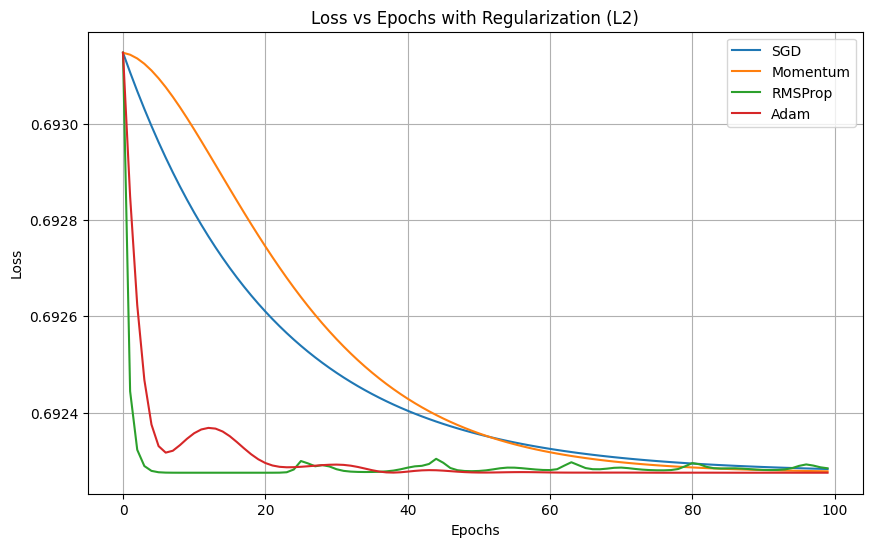

In [15]:
# Plot losses
plt.figure(figsize=(10, 6))
for name, loss in results.items():
    plt.plot(loss, label=name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs with Regularization (L2)')
plt.legend()
plt.grid()
plt.show()

## Code for: `DL3.ipynb`

In [1]:
# Install Required Libraries
# !pip install tensorflow keras-tuner numpy scikit-learn matplotlib pillow
import sys
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install keras-tuner

In [2]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import os

In [3]:
# Load and Preprocess Dataset
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

# Split training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [4]:
# Define a Model Builder for Hyperparameter Tuning
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(keras.Input(shape=(784,)))
    
    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                activation='relu',
                kernel_regularizer=keras.regularizers.l2(hp.Choice('l2', [0.001, 0.0001]))
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            )
        )
    
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [5]:
# Perform Hyperparameter Tuning


# Remove previous tuning logs if they exist
if os.path.exists("my_dir/mnist_tuning"):
    shutil.rmtree("my_dir/mnist_tuning")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning'
)

# Start search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# To recompile with a fresh optimizer
best_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.9035833477973938

Best val_accuracy So Far: 0.9748333096504211
Total elapsed time: 00h 09m 01s


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# Evaluate and Use the Best Model
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9714 - loss: 0.1506    
Test accuracy: 0.9763


In [7]:
# Save the model
best_model.save('best_mnist_model.keras')



In [8]:
# Load later
model = keras.models.load_model('best_mnist_model.keras')

# Recompile the model to avoid optimizer loading warning
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# #Preprocess functions
def preprocess_user_image(path):
    # Load and convert to grayscale
    img = Image.open(path).convert('L')

    # Invert colors: white digit on black bg -> black digit on white bg (MNIST-style)
    img = ImageOps.invert(img)

    # Resize while keeping aspect ratio, add padding to make it square (28x28)
    img.thumbnail((20, 20), Image.Resampling.LANCZOS)
    delta_w = 28 - img.size[0]
    delta_h = 28 - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    img_padded = ImageOps.expand(img, padding, fill=0)

    # Convert to numpy array, normalize
    img_array = np.array(img_padded).astype("float32") / 255.0

    # Flatten
    return img_array.reshape(1, 784), img_array


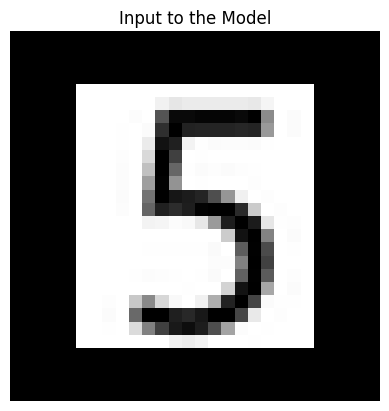

In [10]:
#
# Example usage
image_path = "input5.png"  # Replace with your image file
# input_data = preprocess_image(image_path)
input_data, vis_data = preprocess_user_image("input5.png")

plt.imshow(input_data.reshape(28, 28), cmap='gray')
plt.title("Input to the Model")
plt.axis('off')
plt.show()

In [11]:
# Print prediction probabilities:
probs = best_model.predict(input_data)
print("Class probabilities:", probs)
print("Predicted digit:", np.argmax(probs))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Class probabilities: [[1.53886378e-01 4.81084629e-04 8.80190637e-04 6.37510233e-03
  3.30696665e-02 5.30095279e-01 7.92985559e-02 6.74340967e-03
  6.80493191e-02 1.21121034e-01]]
Predicted digit: 5


In [12]:
#Predict
prediction = best_model.predict(input_data)
predicted_class = np.argmax(prediction)
print(f"Predicted digit: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 5


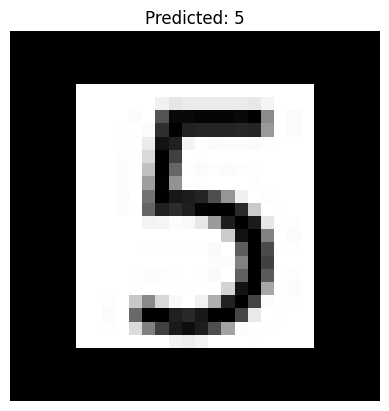

In [13]:
# # Optional: show image
# Visualize final input
plt.imshow(vis_data, cmap='gray')
plt.title(f"Predicted: {np.argmax(probs)}")
plt.axis('off')
plt.show()

In [14]:
#


## Code for: `DL4.ipynb`

In [1]:
# #Step 1: Install Required Libraries
# !pip install tensorflow


In [2]:
#Step 2: Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

In [3]:
#Step 3: Load and Preprocess the Dataset
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape to match CNN input (batch, height, width, channels)
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
#Step 4: Build the CNN Model
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Recommended way to define input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])



In [5]:
#Step 5: Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
#Step 6: Train the Model
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)



Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8738 - loss: 0.4177 - val_accuracy: 0.9780 - val_loss: 0.0717
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9809 - loss: 0.0605 - val_accuracy: 0.9858 - val_loss: 0.0491
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9876 - loss: 0.0406 - val_accuracy: 0.9877 - val_loss: 0.0447
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9909 - loss: 0.0287 - val_accuracy: 0.9902 - val_loss: 0.0366
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9937 - loss: 0.0196 - val_accuracy: 0.9905 - val_loss: 0.0314


In [7]:
#Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9881 - loss: 0.0355
Test accuracy: 0.9901


In [8]:
# Optional: Save the Model
model.save('mnist_cnn_model.keras')

In [9]:
#Load the Trained Model
model = load_model('mnist_cnn_model.keras')  # Use the path where you saved the model



In [12]:
# Load and preprocess the image
img = Image.open('input4.png').convert('L')  # Convert to grayscale
img = img.resize((28, 28))  # Resize to 28x28
img = np.array(img)
img = 255 - img  # Invert colors: MNIST has white digits on black background
img = img / 255.0  # Normalize pixel values
img = img.reshape(1, 28, 28, 1)  # Reshape for model input

In [13]:
## Predict the digit
prediction = model.predict(img)
predicted_digit = np.argmax(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


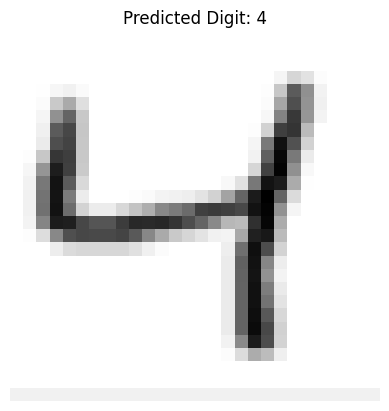

In [14]:
## Display the image and prediction
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis('off')
plt.show()


In [15]:
#


## Code for: `DL5.ipynb`

In [19]:
pip install tensorflow tensorflow-datasets matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [21]:
# === SETTINGS ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5

In [22]:
# === LOAD DATASET ===
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes

In [23]:
# === PREPROCESSING FUNCTION ===
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [24]:
# === BUILD MODEL ===
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [25]:
# === COMPILE & TRAIN ===
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 529ms/step - accuracy: 0.4044 - loss: 1.4408 - val_accuracy: 0.7589 - val_loss: 0.7374
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 543ms/step - accuracy: 0.7414 - loss: 0.7323 - val_accuracy: 0.8229 - val_loss: 0.5362
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - accuracy: 0.8062 - loss: 0.5595 - val_accuracy: 0.8501 - val_loss: 0.4542
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 484ms/step - accuracy: 0.8331 - loss: 0.4884 - val_accuracy: 0.8651 - val_loss: 0.4086
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 512ms/step - accuracy: 0.8512 - loss: 0.4185 - val_accuracy: 0.8747 - val_loss: 0.3798


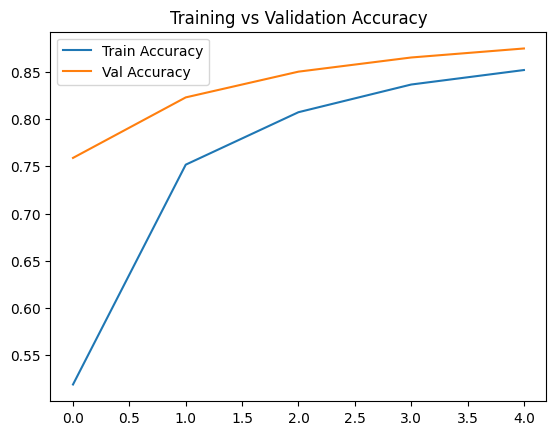

In [26]:
# === PLOT RESULTS ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [27]:
#Save the model
model.save('flower_model.keras')


In [28]:
# === Load model ===
model = tf.keras.models.load_model('flower_model.keras')

In [29]:
# === Load label names from tf_flowers ===
_, ds_info = tfds.load('tf_flowers', split='train', with_info=True)
class_names = ds_info.features['label'].names  # List of class labels

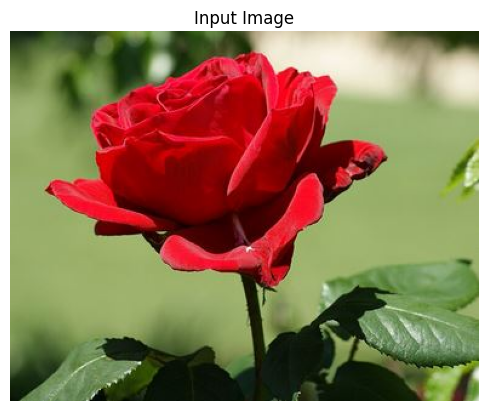

In [30]:
# === Image path ===
image_path = 'input_rose.jpg'  

img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

In [31]:
# === Preprocess the image ===
IMG_SIZE = 224

In [32]:
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

image = load_and_preprocess_image(image_path)

In [33]:
# === Make prediction ===
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0]) * 100

print(f"Predicted: {class_names[predicted_class]} ({confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: roses (60.78%)


## Code for: `DL6.ipynb`

In [1]:
# pip install torch torchvision matplotlib pillow


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
import copy
from IPython.display import display

In [3]:
# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512 if torch.cuda.is_available() else 256

In [4]:
# --- Image Preprocessing ---
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)  # add batch dimension
    return image.to(device, torch.float)

In [5]:
# --- Load Images ---
# content_img = image_loader("path_to_your_content_image.jpg")
content_img = image_loader("D:/DL_lab/DL6/original/dog_normal.jpg")

# style_img = image_loader("path_to_your_style_image.jpg")
style_img = image_loader("D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg")

assert content_img.size() == style_img.size(), "Images must be of same size"

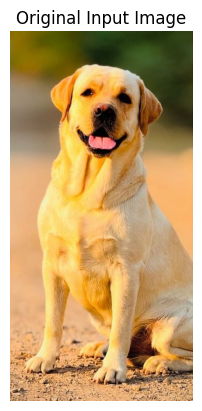

In [6]:
# --- Load Images ---
# content_img = image_loader("D:/DL_lab/DL6/original/dog_normal.jpg")

img_path = "D:/DL_lab/DL6/original/dog_normal.jpg"
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title("Original Input Image")
plt.show()

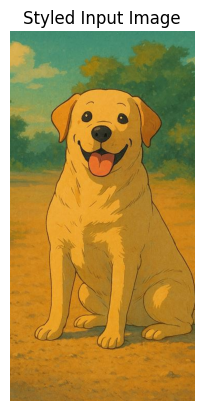

In [7]:
# --- Load Images ---
# style_img = image_loader("D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg")

img_path2 = "D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg"
img2 = Image.open(img_path2)

plt.imshow(img2)
plt.axis('off')
plt.title("Styled Input Image")
plt.show()

In [8]:
# style_pil.show(title="Styled/Reference Image")

In [9]:
# --- Display Function ---
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [10]:
# --- Loss Models ---
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

In [11]:
# # --- Load Pretrained VGG19 and Prepare Model ---
# cnn = models.vgg19(pretrained=True).features.to(device).eval()
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# class Normalization(nn.Module):
#     def __init__(self, mean, std):
#         super().__init__()
#         self.mean = mean.view(-1, 1, 1)
#         self.std = std.view(-1, 1, 1)

#     def forward(self, x):
#         return (x - self.mean) / self.std



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained VGG19 model using the new weights enum
weights = VGG19_Weights.DEFAULT
cnn = models.vgg19(weights=weights).features.to(device).eval()

# Use standard ImageNet normalization values (manually defined)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Normalization layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, x):
        return (x - self.mean) / self.std

In [12]:
# --- Choose Layers for Style and Content ---
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0  # increment every time a conv is added
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Truncate layers after the last content/style loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

In [13]:
# --- Optimization Setup ---
input_img = content_img.clone()
optimizer = optim.LBFGS([input_img.requires_grad_()])

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

In [14]:
# --- Run Style Transfer ---
num_steps = 300
style_weight = 1e6
content_weight = 1

print("Optimizing...")
run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)

        loss = style_weight * style_score + content_weight * content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
        return loss

    optimizer.step(closure)


Optimizing...
Step 50:
Style Loss: 0.0001, Content Loss: 11.1811
Step 100:
Style Loss: 0.0000, Content Loss: 11.7861
Step 150:
Style Loss: 0.0000, Content Loss: 10.4868
Step 200:
Style Loss: 0.0000, Content Loss: 9.3643
Step 250:
Style Loss: 0.0000, Content Loss: 8.1828
Step 300:
Style Loss: 0.0000, Content Loss: 7.3010


In [15]:
# Finalize image
input_img.data.clamp_(0, 1)

tensor([[[[0.5388, 0.6743, 0.6832,  ..., 0.1906, 0.1880, 0.2639],
          [0.6731, 0.7373, 0.6884,  ..., 0.1922, 0.1038, 0.2269],
          [0.7002, 0.7417, 0.7261,  ..., 0.2384, 0.1982, 0.2428],
          ...,
          [0.6793, 0.6460, 0.6262,  ..., 0.7284, 0.6730, 0.6462],
          [0.7130, 0.6999, 0.6691,  ..., 0.6002, 0.5638, 0.5665],
          [0.7035, 0.6903, 0.6721,  ..., 0.6046, 0.5734, 0.6031]],

         [[0.4053, 0.4098, 0.4198,  ..., 0.4146, 0.4657, 0.5439],
          [0.4644, 0.4247, 0.4288,  ..., 0.4659, 0.4179, 0.4979],
          [0.4223, 0.3495, 0.3604,  ..., 0.4029, 0.4059, 0.4060],
          ...,
          [0.4485, 0.4761, 0.4729,  ..., 0.5302, 0.5128, 0.5421],
          [0.4530, 0.4899, 0.4888,  ..., 0.4814, 0.5039, 0.5155],
          [0.5016, 0.4864, 0.4748,  ..., 0.4658, 0.4673, 0.4350]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1414, 0.1463, 0.1262],
          [0.0000, 0.0148, 0.0460,  ..., 0.2498, 0.2264, 0.1483],
          [0.0000, 0.0689, 0.1483,  ..., 0

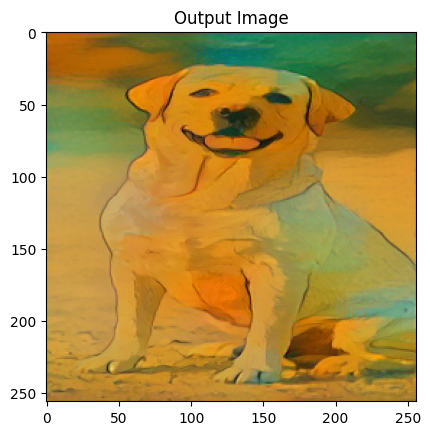

In [16]:
# --- Show Result ---
imshow(input_img, title="Output Image")
plt.show()

## Code for: `DL7.ipynb`

In [1]:
# # Step 1: Install Required Libraries
# !pip install tensorflow numpy


In [2]:
#Step 2: Import Libraries
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import numpy as np


In [3]:
#Step 3: Load and Prepare the Dataset
# Load IMDB dataset
num_words = 10000  # Only use the top 10,000 most frequent words
maxlen = 200       # Pad sequences to max length

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Pad sequences so they are all the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


In [4]:
# #Step 4: Build the RNN Model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=32),  # input_length removed
    SimpleRNN(units=32, activation='tanh'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
#Step 5: Train the Model
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.5498 - loss: 0.6811 - val_accuracy: 0.6740 - val_loss: 0.5969
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7811 - loss: 0.4657 - val_accuracy: 0.7506 - val_loss: 0.5210
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8698 - loss: 0.3236 - val_accuracy: 0.8264 - val_loss: 0.4264


In [6]:
#Step 6: Evaluate the Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")



782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8225 - loss: 0.4387
Test Accuracy: 0.82


In [7]:
#Step 7: Make Predictions
# Reverse lookup to convert indices to words
word_index = imdb.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

# Decode the review
def decode_review(encoded_review):
    return ' '.join([index_word.get(i, '?') for i in encoded_review])

sample = x_test[0]
print("Review:")
print(decode_review(sample))

prediction = model.predict(np.expand_dims(sample, axis=0))[0][0]
print(f"\nPredicted Sentiment: {'Positive' if prediction > 0.5 else 'Negative'} (score={prediction:.2f})")



Review:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this 

In [8]:
#Predict Custom Input
def encode_review(text):
    words = text_to_word_sequence(text)
    encoded = [1]  # 1 is the <START> token
    for word in words:
        index = word_index.get(word)
        if index is not None and index < num_words:
            encoded.append(index + 3)
        else:
            encoded.append(2)  # <UNK>
    return pad_sequences([encoded], maxlen=maxlen)

In [9]:
# Custom review
your_review = "This movie was absolutely wonderful and inspiring"
encoded = encode_review(your_review)

In [10]:
## Prediction
pred = model.predict(encoded)[0][0]
print(f"\nYour review: {your_review}")
print(f"Predicted Sentiment: {'Positive' if pred > 0.5 else 'Negative'} (score={pred:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Your review: This movie was absolutely wonderful and inspiring
Predicted Sentiment: Positive (score=0.85)


In [11]:
#


## Code for: `DL8.ipynb`

In [1]:
# pip install tensorflow matplotlib numpy


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:
#Step 2: Prepare Sequential Data
# Generate a sine wave dataset
x = np.linspace(0, 100, 1000)
y = np.sin(x)

# Prepare sequences for LSTM input
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        Y.append(data[i+look_back])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(y, look_back)

# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [4]:
#Step 3: Build the LSTM Model
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#Step 4: Train the Model
model.fit(X, Y, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3848 
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1099 
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0694 
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174 
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1301e-04 
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9917e-04 
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1664e-04 
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8176e-05 
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0940e-05 
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5671e-05 
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5284e-05 
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0362e-05 
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4699e-06 
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━

In [6]:
#Step 5: Take User Input and Predict

import sys

# Helper: Normalize user input to sine wave scale
def parse_input_sequence():
    try:
        user_input = input(f"Enter {look_back} comma-separated numbers (as sequence): ")
        seq = [float(num) for num in user_input.split(',')]
        if len(seq) != look_back:
            raise ValueError(f"Expected {look_back} values.")
        return np.array(seq).reshape(1, look_back, 1)
    except Exception as e:
        print("Error:", e)
        sys.exit(1)

# Get input and predict
input_seq = parse_input_sequence()
predicted = model.predict(input_seq)
print("Predicted next value:", predicted[0][0])


Enter 10 comma-separated numbers (as sequence):  0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Predicted next value: 0.926805


In [7]:
# Enter 10 comma-separated numbers (as sequence): 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
# Predicted next value: 0.78322196

## Code for: `DL9.ipynb`

In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
# Step 1: Load the emoji dataset
dataset = load_dataset("tweet_eval", "emoji")


In [3]:
# Step 2: Convert to Pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

In [4]:
# Optional: Combine train and test sets (or use train only)
df = pd.concat([train_df, test_df], ignore_index=True)

In [5]:
# Step 3: Prepare features and labels
X = df['text']
y = df['label']

In [6]:
# Step 4: Encode the labels to emojis
label_mapping = dataset['train'].features['label'].names
label_encoder = LabelEncoder()
label_encoder.fit(range(len(label_mapping)))
y_labels = label_encoder.transform(y)

In [7]:
# Step 5: Vectorize text using TF-IDF
# vectorizer = TfidfVectorizer(max_features=1000)
# X_vectorized = vectorizer.fit_transform(X)
# Increase number of features from 1000 to 5000
vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(df['text'])

In [8]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_labels, test_size=0.2, random_state=42)


In [9]:
# Step 7: Train classifier
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train, y_train)
# Add class_weight='balanced' to help with imbalance
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [10]:
# Step 8: Evaluate performance
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping))


Classification Report:
              precision    recall  f1-score   support

           ❤       0.51      0.09      0.16      4104
           😍       0.29      0.16      0.21      1966
           😂       0.44      0.31      0.36      1838
           💕       0.14      0.15      0.14       942
           🔥       0.42      0.39      0.40      1154
           😊       0.08      0.08      0.08       740
           😎       0.14      0.13      0.14       780
           ✨       0.23      0.23      0.23      1037
           💙       0.09      0.17      0.12       525
           😘       0.10      0.23      0.14       488
           📷       0.15      0.21      0.18       714
          🇺🇸       0.36      0.55      0.44       554
           ☀       0.23      0.51      0.32       520
           💜       0.08      0.16      0.11       442
           😉       0.08      0.14      0.10       518
           💯       0.12      0.29      0.17       397
           😁       0.07      0.12      0.09       481
    

In [11]:
# Step 9: Emoji prediction function
def predict_emoji(text):
    vec = vectorizer.transform([text])
    pred_label = clf.predict(vec)[0]
    return label_mapping[pred_label]

In [15]:
# Step 10: Interactive prediction
while True:
    sentence = input("Enter a sentence (or 'exit' to stop): ")
    if sentence.lower() == 'exit':
        break
    emoji = predict_emoji(sentence)
    print("Predicted Emoji:", emoji)

Enter a sentence (or 'exit' to stop):  exit


## Code for: `DL10.ipynb`

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

english_sentences = [
    'hello', 'how are you?', 'good morning', 'what is your name?', 'I love programming',
    'I am learning machine learning', 'this is a great day', 'how is the weather?', 'I feel happy today',
    'thank you very much', 'can you help me?', 'I am going to the store', 'do you want coffee?', 'I need a break'
]

french_sentences = [
    'bonjour', 'comment ça va?', 'bonjour', 'quel est ton nom?', 'j\'aime la programmation',
    'j\'apprends l\'apprentissage automatique', 'c\'est une belle journée', 'comment est le temps?', 'je me sens bien aujourd\'hui',
    'merci beaucoup', 'peux-tu m\'aider?', 'je vais au magasin', 'veux-tu du café?', 'j\'ai besoin d\'une pause'
]


# Preprocess Data

# Tokenize English and French sentences
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequences = eng_tokenizer.texts_to_sequences(english_sentences)
eng_max_len = max([len(seq) for seq in eng_sequences])
eng_padded = pad_sequences(eng_sequences, maxlen=eng_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(french_sentences)
fr_vocab_size = len(fr_tokenizer.word_index) + 1
fr_sequences = fr_tokenizer.texts_to_sequences(french_sentences)
fr_max_len = max([len(seq) for seq in fr_sequences])
fr_padded = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

# Define the NMT Model (Encoder-Decoder)

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=256)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=fr_vocab_size, output_dim=256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Build the Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare Decoder Output for Training
decoder_output_data = np.expand_dims(fr_padded, -1)

# Train the Model
model.fit([eng_padded, fr_padded], decoder_output_data, epochs=100, batch_size=2)

# Separate the encoder model to get encoder states
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Create the decoder model for prediction
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_state_inputs)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs, state_h, state_c])

# Translate a New Sentence
def translate_sentence(input_sentence):
    # Tokenize input sentence
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len, padding='post')

    # Get the encoder's states
    states_value = encoder_model.predict(input_seq)

    # Prepare initial input for the decoder
    target_seq = np.zeros((1, 1))  # Start token (usually 0 or a specific token)

    decoded_sentence = ''
    for _ in range(fr_max_len):
        output_tokens, state_h, state_c = decoder_model.predict([target_seq] + states_value)

        # Get the predicted word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = fr_tokenizer.index_word.get(sampled_token_index, '')

        decoded_sentence += ' ' + sampled_word

        # Exit condition: when the predicted word is the <end> token
        if sampled_word == '<end>' or sampled_token_index == 0:
            break

        # Update the target sequence and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [state_h, state_c]

    return decoded_sentence


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.1915 - loss: 3.6686
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4137 - loss: 3.1459
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4112 - loss: 2.4371
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.2699 - loss: 2.7933
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3316 - loss: 2.4833
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3860 - loss: 2.2329
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5242 - loss: 1.8535
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3707 - loss: 2.3148
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3886 - loss: 2.0246
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4554 - loss: 1.9893
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4965 - loss: 1.5688
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6560 - lo

In [ ]:
# # Test Translation
input_sentence = 'Hello'
translated_sentence = translate_sentence(input_sentence)
print(f"Translated sentence: {translated_sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Translated sentence:  bonjour 


## Code for: `DL11.ipynb`

In [1]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [2]:
# #Step 1: Install Required Libraries
# !pip install spacy
# !python -m spacy download en_core_web_sm



In [3]:
# Named Entity Recognition using spaCy
# Step 1: Import spaCy
import spacy

In [4]:
# Step 2: Load the English NLP model
nlp = spacy.load("en_core_web_sm")


In [10]:
# Step 3: Take input from user
user_input = input("Enter a sentence for NER: ")
# Elon Musk's Tesla (the United States) stock is more valuable than companies like Ford, Ferrari, Volkswage, BMW combined in the year 2025!
# Barack Obama was born in Hawaii and became the President of the United States in 2009.


Enter a sentence for NER:  Elon Musk's Tesla (the United States) stock is more valuable than companies like Ford, Ferrari, Volkswage, BMW combined in the year 2025!


In [11]:
# Step 4: Process the input text
doc = nlp(user_input)


In [12]:
# Step 5: Print named entities, their labels, and positions
print("\nNamed Entities and their Labels:")
print("----------------------------------")
for ent in doc.ents:
    print(f"Text: {ent.text}\tLabel: {ent.label_}\t(Start: {ent.start_char}, End: {ent.end_char})")



Named Entities and their Labels:
----------------------------------
Text: Elon Musk's	Label: PERSON	(Start: 0, End: 11)
Text: Tesla	Label: PERSON	(Start: 12, End: 17)
Text: the United States	Label: GPE	(Start: 19, End: 36)
Text: Ford	Label: ORG	(Start: 81, End: 85)
Text: Ferrari	Label: GPE	(Start: 87, End: 94)
Text: Volkswage	Label: ORG	(Start: 96, End: 105)
Text: BMW	Label: ORG	(Start: 107, End: 110)
Text: the year 2025	Label: DATE	(Start: 123, End: 136)


In [8]:
#


In [9]:
#


## Code for: `DL12.ipynb`

In [1]:
# pip install sounddevice wavio speechrecognition scikit-learn


In [2]:
import tkinter as tk
from tkinter import messagebox
import sounddevice as sd
import wavio
import speech_recognition as sr
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import os
import webbrowser

In [3]:
# --- Define actions based on trigger words ---
ACTIONS = {
    "open browser": lambda: webbrowser.open("https://www.google.com"),
    "start notepad": lambda: os.system("notepad.exe")  # Windows only
}

In [4]:
# --- Training data (keywords) ---
phrases = list(ACTIONS.keys()) + [
    "hey assistant", "hello", "hi bot", "wake up", "activate",
    "what time is it", "tell me a joke", "how are you", "stop listening", "good morning"
]
labels = [1] * len(ACTIONS) + [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]  # 1 = trigger, 0 = non-trigger


In [5]:
# --- ML model ---
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(phrases, labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [6]:
# --- Audio functions ---
def record_audio(filename="recording.wav", duration=5, fs=44100):
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    wavio.write(filename, recording, fs, sampwidth=2)

def transcribe_audio(filename="recording.wav"):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio)
    except:
        return ""

In [7]:
# --- Detection logic ---
def detect_trigger(text):
    if not text.strip():
        return "No speech detected."
    prediction = model.predict([text])[0]
    if prediction == 1:
        for phrase in ACTIONS:
            if phrase in text.lower():
                ACTIONS[phrase]()  # Perform action
                return f"✅ Trigger '{phrase}' detected. Action executed!"
        return "✅ Trigger word detected!"
    else:
        return "❎ Not a trigger word."

def run_detection():
    record_audio()
    text = transcribe_audio()
    result = detect_trigger(text)
    messagebox.showinfo("Result", f"You said: {text}\n\n{result}")

In [8]:
# --- GUI Setup ---
root = tk.Tk()
root.title("Trigger Word Detector with Actions")

tk.Label(root, text="🎤 Speak a command like 'open browser'...").pack(pady=10)
tk.Button(root, text="Start Listening", command=run_detection, width=30).pack(pady=10)
tk.Label(root, text="(Records for 5 seconds)").pack(pady=5)

root.mainloop()